In [1]:
import pandas as pd
import numpy as np
import os
import requests
%matplotlib inline

In [5]:
pd.to_datetime('1 jan 2017').tz_localize('UTC').tz_convert('US/Eastern')

Timestamp('2016-12-31 19:00:00-0500', tz='US/Eastern')

In [2]:
print(pd.__version__)

0.25.0


2 ways to concat: Either append all dataframes into an empty list and then concat all in one step, or create an empty dataframe initially, then concat each consecutive df to the previous one.

In [3]:
PATH = '2017-capitalbikeshare-tripdata'
# df_list = []
data_2017=pd.DataFrame()
for csv in os.listdir(path=PATH):
    df=pd.read_csv(f'{PATH}/{csv}')
#     df_list.append(df)
    data_2017 = pd.concat([data_2017, df], sort=True)
    
# data_2017 = pd.concat(df_list)

In [4]:
data_2017.isna().sum() #no missing data!

Bike number             0
Duration                0
End date                0
End station             0
End station number      0
Member type             0
Start date              0
Start station           0
Start station number    0
dtype: int64

In [5]:
data_2017['Start date'] = pd.to_datetime(data_2017['Start date'])
data_2017['End date'] = pd.to_datetime(data_2017['End date'])
data_2017['Duration'] = data_2017['End date'] - data_2017['Start date']

data_2017['Month'] = data_2017['Start date'].dt.month
data_2017['Day'] = data_2017['Start date'].dt.day
data_2017['Hour'] = data_2017['Start date'].dt.hour
data_2017['Weekday'] = data_2017['Start date'].dt.weekday

---

### DarkSky API Temperature Stuff 

In [ ]:
timecodes = []
# 86400 -> seconds in a day
for i in range(366):
    #for whole year
    
    val = 1483246800 + 86400*i
    timecodes.append(val)

couldn't get all cause internet dropped mid-way...

### Careful running the code below, since you only have 1000 free requests per day!!
- **Commenting it out for safety**
- **(Just read from the CSV saved to the disk, if you're reaching the limit for the day)**

---

In [ ]:
# temp_dfs = []
# for i,t in enumerate(timecodes):
    
#     result = requests.get(f'https://api.darksky.net/forecast/a2b30bd526c3b5962010ec6b3f0dd7bc/38.904722,-77.016389,{t}')
#     result_json = result.json()
#     temps = pd.DataFrame(result_json['hourly']['data'])
#     temps['time'] = pd.to_datetime(temps['time'], unit='s')
    
#     temp_dfs.append(temps)
    
#     if i % 50 == 0:
#         percentage = i/len(timecodes) * 100
#         print(f'{round(percentage)}% complete...')
        
#     elif t == timecodes[-1]:
#         print('Done!!')


In [ ]:
# all_temps = pd.concat(temp_dfs, sort=True)
# all_temps.to_csv('2017_temps_almost_all.csv')

### Careful running the code above, since you only have 1000 free requests per day!!
**(Just pick it up from here with the CSV saved to the disk, if you're reaching the limit for the day)**

In [6]:
all_temps = pd.read_csv('2017_temps_almost_all.csv', index_col=0)
# all_temps['time'] = all_temps['time'].str[:-6] #just a quick fix to remove the TZ formatting from before
all_temps['time'] = pd.to_datetime(all_temps['time'])

In [7]:
all_temps['time'] = all_temps['time'].dt.tz_localize('UTC',nonexistent='shift_forward').dt.tz_convert(tz='US/Eastern')
#the tz_localize makes the time aware of the fact that it has a timezone (i.e. gives it geographical awarness)
#and then once the time is "localized", it can be converted to US/Eastern

temps_final = all_temps[['time', 'humidity', 'temperature', 'precipIntensity', 'windSpeed', 'icon']]

just testing...

In [ ]:
# daterange_test = pd.date_range(start='jan 1 2018', end='jan 31 2018', freq='h')

In [ ]:
# daterange_test.tz_localize('UTC').tz_convert('US/Eastern')

In [8]:
temps_final.head()

,time,humidity,temperature,precipIntensity,windSpeed,icon
0,2017-01-01 00:00:00-05:00,0.42,44.85,0.0,3.92,partly-cloudy-night
1,2017-01-01 01:00:00-05:00,0.43,44.52,0.0,3.28,partly-cloudy-night
2,2017-01-01 02:00:00-05:00,0.46,43.37,0.0,1.53,partly-cloudy-night
3,2017-01-01 03:00:00-05:00,0.48,42.00,0.0,0.97,partly-cloudy-night
4,2017-01-01 04:00:00-05:00,0.52,40.37,0.0,0.68,clear-night


---

### Now back to the 2017 rental data

In [10]:
data_2017['Duration (s)'] = data_2017['Duration'] / np.timedelta64(1, 's')

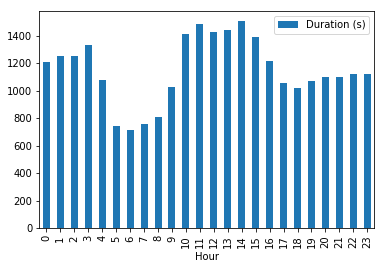

In [11]:
data_2017.groupby('Hour')[['Duration (s)']].mean().plot.bar()

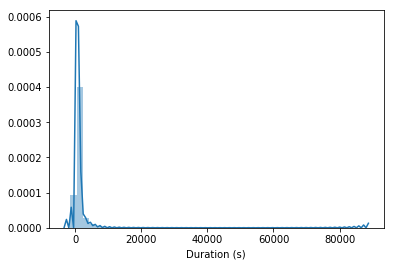

In [12]:
import seaborn as sns
sns.distplot(data_2017['Duration (s)'])

In [13]:
#for getting additional information about the stations, like lat/long
response = requests.get('https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json')
stations = pd.DataFrame(response.json()['data']['stations'])

In [14]:
stations['region_id'].unique()

array([ 41.,  42.,  40.,  44.,  43., 104., 133., 152.,  nan])

In [15]:
stations.head(2)

,station_id,external_id,name,short_name,lat,lon,region_id,rental_methods,capacity,rental_url,electric_bike_surcharge_waiver,eightd_has_key_dispenser,eightd_station_services,has_kiosk
0,8,08246f1f-1f3f-11e7-bf6b-3863bb334450,Crystal City Metro / 18th St & S Bell St,31007,38.857405,-77.051132,41.0,"[CREDITCARD, KEY]",19,http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,False,True,[{'id': '6b85866a-618f-4b75-9a20-c34edb150fb8'...,True
1,53,082492e1-1f3f-11e7-bf6b-3863bb334450,21st & M St NW,31212,38.905340,-77.046774,42.0,"[CREDITCARD, KEY]",19,http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,False,False,[{'id': '5de25767-74ce-4d4b-b4b2-d8a51bb73295'...,True


In [16]:
stations_short = stations[['lat', 'lon', 'name', 'capacity', 'short_name', 'station_id']]
#562 unique stations total

In [17]:
stations_short['short_name'] = stations_short['short_name'].astype(np.int64)

/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
stations_short.head()

,lat,lon,name,capacity,short_name,station_id
0,38.857405,-77.051132,Crystal City Metro / 18th St & S Bell St,19,31007,8
1,38.905340,-77.046774,21st & M St NW,19,31212,53
2,38.902221,-77.059219,Georgetown Harbor / 30th St NW,19,31215,72
3,38.900283,-77.029822,13th St & New York Ave NW,23,31227,91
4,38.902061,-77.038322,17th & K St NW / Farragut Square,35,31233,106


In [19]:
df_merged = pd.merge(data_2017, stations_short, how='inner', left_on='Start station number', right_on='short_name')
# few stations in the main dataset didn't exist in the stations df, so doing inner merge to drop the NAs
# alternatively, do a left join and then drop NAs

In [20]:
data_2017.shape

(3757777, 14)

In [21]:
df_merged.shape

(3751252, 20)

In [ ]:
# rentals_day_location = df_merged.groupby(['Day','Start station number'])[['Bike number']].count()

--- 
Also merging weather data onto the 2017 rental data... 

---

In [22]:
### BUT FIRST WE NEED TO LOCALIZE THE TIME TO US/EASTERN, SO THAT WE CAN MERGE DATA
df_merged['Start date TZ'] = df_merged['Start date'].dt.tz_localize('US/Eastern', ambiguous='NaT')

In [23]:
df_merged.dropna(inplace=True) #due to some weird daylight savings time shit, lost 100 rows or so. Whatevs.

In [24]:
df_merged.head(2)

,Bike number,Duration,End date,End station,End station number,Member type,Start date,Start station,Start station number,Month,...,Hour,Weekday,Duration (s),lat,lon,name,capacity,short_name,station_id,Start date TZ
0,W00869,00:03:42,2017-01-01 00:04:23,M St & New Jersey Ave SE,31208,Member,2017-01-01 00:00:41,3rd & Tingey St SE,31634,1,...,0,6,222.0,38.87501,-77.0024,3rd & Tingey St SE,19,31634,273,2017-01-01 00:00:41-05:00
1,W21871,00:13:19,2017-01-01 12:07:37,D St & Maryland Ave NE,31612,Member,2017-01-01 11:54:18,3rd & Tingey St SE,31634,1,...,11,6,799.0,38.87501,-77.0024,3rd & Tingey St SE,19,31634,273,2017-01-01 11:54:18-05:00


In [25]:
df_merged.shape

(3751149, 21)

In [29]:
print(f'After preparing the 2017 data and merging with supplemental data, number of rows remaining:\n\
{df_merged.shape[0]}')

After preparing the 2017 data and merging with supplemental data, number of rows remaining:
3751149


### Method 1: Use merge_asof to try to join them to the closest times

In [30]:
df_merged_final_v1 = pd.merge_asof(df_merged.sort_values(by='Start date TZ'), temps_final.sort_values(by='time'), left_on='Start date TZ', right_on='time')

In [31]:
df_merged_final_v1.shape

(3751149, 27)

In [32]:
df_merged_final_v1.isna().sum() #No missing values, so it worked well!

Bike number             0
Duration                0
End date                0
End station             0
End station number      0
Member type             0
Start date              0
Start station           0
Start station number    0
Month                   0
Day                     0
Hour                    0
Weekday                 0
Duration (s)            0
lat                     0
lon                     0
name                    0
capacity                0
short_name              0
station_id              0
Start date TZ           0
time                    0
humidity                0
temperature             0
precipIntensity         0
windSpeed               0
icon                    0
dtype: int64

### Method 2: Round the 2017 data start times to the nearest hour, then merge the weather data on that (since it, too, is also on an hourly level)

In [231]:
df_merged['Start date TZ rounded'] = df_merged['Start date TZ'].dt.floor('h')

In [232]:
df_merged.head(2)

,Bike number,Duration,End date,End station,End station number,Member type,Start date,Start station,Start station number,Month,...,Weekday,Duration (s),lat,lon,name,capacity,short_name,station_id,Start date TZ,Start date TZ rounded
0,W00869,00:03:42,2017-01-01 00:04:23,M St & New Jersey Ave SE,31208,Member,2017-01-01 00:00:41,3rd & Tingey St SE,31634,1,...,6,222.0,38.87501,-77.0024,3rd & Tingey St SE,19,31634,273,2017-01-01 00:00:41-05:00,2017-01-01 00:00:00-05:00
1,W21871,00:13:19,2017-01-01 12:07:37,D St & Maryland Ave NE,31612,Member,2017-01-01 11:54:18,3rd & Tingey St SE,31634,1,...,6,799.0,38.87501,-77.0024,3rd & Tingey St SE,19,31634,273,2017-01-01 11:54:18-05:00,2017-01-01 11:00:00-05:00


In [233]:
df_merged_final_v2 = pd.merge(df_merged, temps_final, how='inner', left_on='Start date TZ rounded', right_on='time')

In [234]:
df_merged_final_v2.shape

(2249378, 28)

**lose a lot of data this way, somehow, though!**
- **I suspect, however, is because I wasn't able to get all the weather data from the API without being rate-limited, whereas the merge_asof method seemed to work perfectly since it merged the closest things!** 

Let's use the one with less data, since we can only train a model on what we have left after NA values, anyways!

### Stations with highest demand

In [235]:
df_merged_final_v2.groupby('Start station')['Bike number'].count().sort_values(ascending=False).head()

Start station
Columbus Circle / Union Station         40974
Lincoln Memorial                        40737
Jefferson Dr & 14th St SW               39271
Massachusetts Ave & Dupont Circle NW    29372
Jefferson Memorial                      27399
Name: Bike number, dtype: int64

In [236]:
df_merged_final_v2.groupby('Start station number')['Bike number'].count().sort_values(ascending=False).head()

Start station number
31623    40974
31258    40737
31247    39271
31200    29372
31249    27399
Name: Bike number, dtype: int64

In [237]:
lincoln = df_merged_final_v2[df_merged_final_v2['Start station number'] == 31258]

In [238]:
lincoln.head(2)

,Bike number,Duration,End date,End station,End station number,Member type,Start date,Start station,Start station number,Month,...,short_name,station_id,Start date TZ,Start date TZ rounded,time,humidity,temperature,precipIntensity,windSpeed,icon
1,W00894,00:27:56,2017-01-01 00:34:49,8th & D St NW,31270,Casual,2017-01-01 00:06:53,Lincoln Memorial,31258,1,...,31258,204,2017-01-01 00:06:53-05:00,2017-01-01 00:00:00-05:00,2017-01-01 00:00:00-05:00,0.42,44.85,0.0,3.92,partly-cloudy-night
2,W22786,00:27:16,2017-01-01 00:34:52,8th & D St NW,31270,Casual,2017-01-01 00:07:36,Lincoln Memorial,31258,1,...,31258,204,2017-01-01 00:07:36-05:00,2017-01-01 00:00:00-05:00,2017-01-01 00:00:00-05:00,0.42,44.85,0.0,3.92,partly-cloudy-night


In [283]:
features = [
            'Month', 
#             'Day', 
            'Hour', 
            'Weekday',
            'humidity', 
            'temperature', 
#             'precipIntensity', 
#             'windSpeed', 
#             'icon'
    
]

In [284]:
lincoln_data = lincoln.groupby(features)['Bike number'].count().reset_index().rename(columns={'Bike number': 'Rental Count'})

In [285]:
# sns.heatmap(lincoln_data.corr())

In [286]:
# lincoln_data.groupby('icon')['Rental Count'].mean().sort_values().plot.bar()

In [288]:
### Based on the above hierarchy, maybe I can factorize the icons based on those numbers?
d = {'sleet':1,
     'snow': 2,
     'fog': 3,
     'rain': 4,
     'partly-cloudy-night':5,
     'clear-night':6,
     'cloudy':7, 
     'clear-day':8, 
     'partly-cloudy-day':9}

# lincoln_data['icon'] = lincoln_data['icon'].map(d)

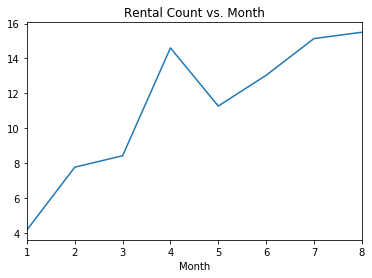

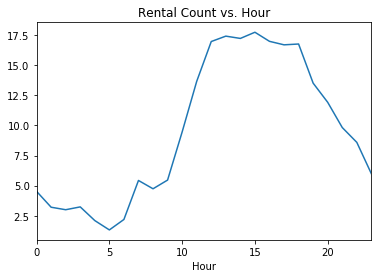

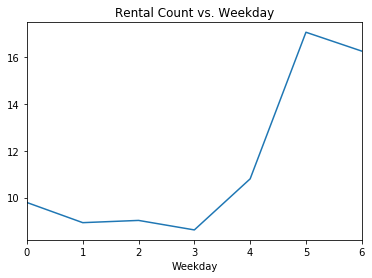

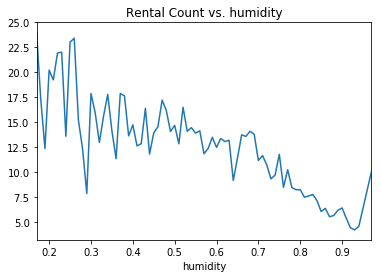

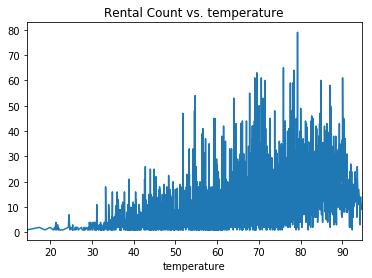

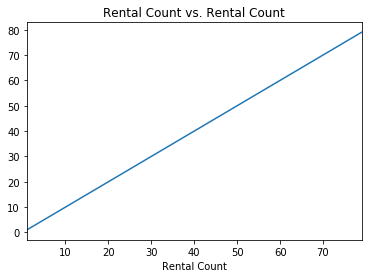

In [309]:
import matplotlib.pyplot as plt
for col in lincoln_data.columns:
    plt.figure()
    lincoln_data.groupby(col)['Rental Count'].mean().plot()
    plt.title(f'Rental Count vs. {col}')
    

In [290]:
lincoln_X = lincoln_data.loc[:, lincoln_data.columns != 'Rental Count']
lincoln_y = lincoln_data['Rental Count']

In [291]:
# lincoln_X.head()

In [292]:
# lincoln_data.groupby(['Weekday','Hour'])['Rental Count'].sum().plot()

In [293]:
from sklearn.model_selection import train_test_split

In [294]:
lincoln_X_train, lincoln_X_test, lincoln_y_train, lincoln_y_test = train_test_split(lincoln_X, lincoln_y)

In [295]:
lincoln_X_train.shape, lincoln_X_test.shape, lincoln_y_train.shape, lincoln_y_test.shape

((2641, 5), (881, 5), (2641,), (881,))

In [296]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression

models=[RandomForestRegressor(), 
        AdaBoostRegressor(), 
        GradientBoostingRegressor(),
        LinearRegression()
       ]
model_names=['RandomForestRegressor',
             'AdaBoostRegressor',
             'GradientBoostingRegressor',
             'LinearRegression'
            ]

In [297]:
# RMSLE_vals = [] # ROOT MEAN SQUARED LOG ERROR
r_squared_train_vals = []
r_squared_test_vals = []
results = {}

for i, model in enumerate(models):
    m=models[i]
    m.fit(lincoln_X_train, lincoln_y_train)
    rtrain = m.score(lincoln_X_train, lincoln_y_train)
    r_squared_train_vals.append(rtrain)
    
    rtest = m.score(lincoln_X_test, lincoln_y_test)
    r_squared_test_vals.append(rtest)
#     ypred = m.predict(Xtest)
    
    
    
#     rmsle = np.sqrt(mean_squared_log_error(ypred, ytest))
#     RMSLE_vals.append(rmsle)
    
results={'Model':model_names,'R-Squared Train':r_squared_train_vals, 'R-Squared Test':r_squared_test_vals} 
pd.DataFrame(results) ### FINAL RESULTS

/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Model,R-Squared Train,R-Squared Test
0,RandomForestRegressor,0.932374,0.579305
1,AdaBoostRegressor,0.528633,0.454477
2,GradientBoostingRegressor,0.676595,0.594132
3,LinearRegression,0.373225,0.354957


^Obviously pretty crap, but of course i've hardly done any feature eng. or model optimization. Some other ideas: try not to create a model for one particular station, but rather a model for each neighborhood / block / region. Also could try out doing a proper time-series analysis (e.g. exponential smoothing, ARIMA, fbprophet). But as a proof of concept this is a pretty fun & interesting data set with lots of potential.

In [221]:
# from sklearn.metrics import mean_squared_log_error

# ypred = rf.predict(lincoln_X_test)

# rmsle = np.sqrt(mean_squared_log_error(ypred, lincoln_y_test))

# rmsle

In [304]:
df_merged.columns

Index(['Bike number', 'Duration', 'End date', 'End station',
       'End station number', 'Member type', 'Start date', 'Start station',
       'Start station number', 'Month', 'Day', 'Hour', 'Weekday',
       'Duration (s)', 'lat', 'lon', 'name', 'capacity', 'short_name',
       'station_id', 'Start date TZ', 'Start date TZ rounded'],
      dtype='object')

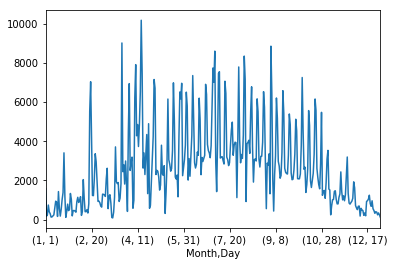

In [307]:
df_merged[df_merged['Member type'] == 'Casual'].groupby(['Month', 'Day'])['Bike number'].count().plot()

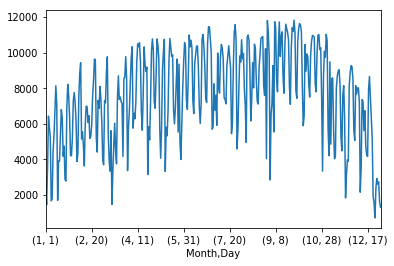

In [308]:
df_merged[df_merged['Member type'] == 'Member'].groupby(['Month', 'Day'])['Bike number'].count().plot()

In [313]:
df_merged.columns

Index(['Bike number', 'Duration', 'End date', 'End station',
       'End station number', 'Member type', 'Start date', 'Start station',
       'Start station number', 'Month', 'Day', 'Hour', 'Weekday',
       'Duration (s)', 'lat', 'lon', 'name', 'capacity', 'short_name',
       'station_id', 'Start date TZ', 'Start date TZ rounded'],
      dtype='object')